In [210]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels as sm
# %matplotlib inline
pd.options.display.max_columns = None
def increase_figsize(N, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    if type(N) is tuple:
        params.set_size_inches((plSize[0]*N[0], plSize[1]*N[1]))
    else:
        params.set_size_inches((plSize[0]*N, plSize[1]*N))
def increase_size_by(N, fontsize, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
            
# Setting some default params. 
cbf = ['#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00']
cbf_map = mpl.colors.ListedColormap(cbf)
rc = {'axes.facecolor': 'white', 'axes.edgecolor': '.15', 'axes.axisbelow': True, 'figure.facecolor': 'white',
      'axes.labelcolor': '.15',  'text.color': '.25',
      'patch.force_edgecolor': True, 'patch.edgecolor': 'w',
      'xtick.bottom': True, 'ytick.left': True, 'xtick.color': '.15', 'ytick.color': '.15',
      'grid.linestyle': '-', 'axes.grid': False, 'grid.color': '.8', 
      'font.size': 30, 
      'xtick.labelsize': 15, 'ytick.labelsize': 15, 
      'axes.titlesize': 22,
      'axes.labelsize': 15,
      'legend.fontsize': 18, 'legend.title_fontsize': 30,
      }
sns.set(rc=rc)
sns.set_palette(cbf)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def percentage(x): 
    return x / x.sum()

from pandas.core.base import PandasObject

PandasObject.set_columns = lambda df, values: df.T.set_index(values).T

In [5]:
has_header = True  # this can be made with the preprocessing file 'patches/remove_double_genomes.py' or 'patches/summary'
data_folder = '/home/hielke/bep/res/'
fig_folder = '/home/hielke/bep/figs/FOR_PUB/'
first_order = 'A'
second_order = 0
save = False
title_mod = ""
def save_fig(ax=None, save=save, plt=plt, title=None):
    if not save: 
        return 
    
    if not ax: 
        ax = plt.gca()
        
    title = title or (g.fig._suptitle._text 
                      if type(ax) is sns.axisgrid.FacetGrid 
                      else ax.get_title())
    
    global second_order
    second_order += 1
    
    dest = fig_folder + first_order + str(second_order) + "___" \
        + title.replace(" ", "_") + ".png"
    plt.savefig(dest, format='png', bbox_inches='tight')
    print("figure saved in " + dest)

# READ IN DATA

In [6]:
if has_header:
    df = pd.read_csv(data_folder + 'hits.tsv.header', sep='\t', 
                    index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str, 'spacer_pos': int, 'spacer_size': int}
                    ).set_index('genome_id')
else:
    df = pd.read_csv(data_folder + 'gene.matched.tsv.smallarraycheck', sep='\t', 
                 names=['genome_key', 'genome_id', 'contig_hit', 'c_1', 'c_2', 'spacer_id', 'hit_ident', 'spacer_size', 
                        'contig_size', '3_prime', '5_prime', 'array_id', 'array_size', 'array_confid', 'repeat_size', 'array_type', 'genome_type',
                        'PAM_confid', 'poss_PAM', 'PAM_side', 'phage_class', 'with_phage',  'gene_hit', 'gene_id', 'gene_class'],
                index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str}).set_index('genome_id')
df.drop(['3_prime', '5_prime', 'genome_key',], axis=1, inplace=True)
df.head()

,contig_hit,c_1,c_2,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,spacer_pos,rel_spacer_pos,name_spacer_pos
genome_id,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,JQGS01000037,11782,11751,JQGS01000065_1_1,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGCTAAAG,3,2,2,RNA+,JQGS01000037_19,UNKNOWN,1,0.000000,leader
100053.4,JQGS01000037,13121,13089,JQGS01000134_1_4,100.00,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,2,AGGAACTCAT,3,2,2,RNA+,JQGS01000037_20,UNKNOWN,4,0.750000,middle
100053.4,JQGS01000037,1789,1757,JQGS01000065_1_2,100.00,33,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGAATCCG,3,2,2,INTERGENIC,NULL,NULL,2,0.090909,middle
100053.4,JQGS01000037,22144,22112,JQGS01000134_1_5,96.97,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,0,ATTTCGAGGT,3,2,2,RNA-,JQGS01000037_36,UNCLASSIFIED,5,1.000000,tail
100053.4,JQGS01000037,24519,24550,JQGS01000065_1_12,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTCGAATTC,3,2,2,RNA+,JQGS01000037_38,UNCLASSIFIED,12,1.000000,tail


In [7]:
df_contigs_size = pd.read_csv(data_folder + 'contig_metadata_patric_genomes', sep='\t', 
                        names=['genome_id', 'contig', 'size'], 
                         dtype={'genome_id': str, 'size': int}).set_index('genome_id')
df_contigs_size.head()

,contig,size
genome_id,,
100053.4,JQGS01000001,2023
100053.4,JQGS01000002,25623
100053.4,JQGS01000003,11202
100053.4,JQGS01000004,109309
100053.4,JQGS01000005,13452


In [8]:
df_genome_info = pd.read_csv(data_folder + 'genome_info', sep='\t',
                            names=['genome_id', 'name'],
                            dtype={'genome_id': str}).set_index('genome_id')
df_genome_info.head()

,name
genome_id,
100053.4,Leptospira alexanderi strain 56650
100053.5,Leptospira alexanderi strain 56643
100053.6,Leptospira alexanderi strain 56640
100053.7,Leptospira alexanderi strain 56159
100053.8,Leptospira alexanderi strain 56659


In [9]:
df_phages = pd.read_csv(data_folder + 'phages.coords.tsv', sep='\t',
                       names=['genome_id', 'contig', 'phage_group', 's', 'e', 'gene_start', 'gene_end'],
                       dtype={'genome_id': str}).set_index('genome_id')
df_phages.head()

,contig,phage_group,s,e,gene_start,gene_end
genome_id,,,,,,
319705.57,FSBC01000007,5.0,121280.0,137206.0,123.0,147.0
319705.57,FSBC01000002,6.0,668178.0,704876.0,652.0,693.0
1639.811,JOYB01000007,2.0,159.0,34964.0,2.0,57.0
1639.811,JOYB01000014,2.0,NaN,NaN,NaN,NaN
1639.811,JOYB01000005,3.0,2250.0,51967.0,2.0,58.0


In [10]:
def seq_iter(filehandle):
    for seq_id in filehandle:
        yield seq_id.strip()[1:], next(filehandle).strip()
spacers = seq_iter(open(data_folder + 'all_spacers.fna.hits'))
all_seq = pd.DataFrame(spacers, 
                     columns=['spacer_id', 'seq'])
all_seq.head()

,spacer_id,seq
0,JQGS01000134_1_2,TGTCATAGATTCGGACAAAACAATTGCTTTTAC
1,JQGS01000134_1_3,GAATTCACCGGAGGGCCTGACGAAGATTCACAA
2,JQGS01000134_1_4,GTATTTTTCAATGATTATCTTTATGGATTCAGG
3,JQGS01000134_1_5,GGCGGATATAATTTGAAGATGAGTAACATTGAA
4,JQGS01000065_1_1,GATCATTTCTTTATTCTCTGCGAGGAGCATAT


### Remove uninteresting duplicates

In [11]:
df = df.reset_index().merge(all_seq, how='left', on='spacer_id', validate='m:1').set_index('genome_id')

In [12]:
# Remove double arrays (same seq, same hit, same array location)
df = df.reset_index().groupby(['seq', 'c_1', 'c_2', 'contig_hit', 'spacer_pos']).first().reset_index().set_index('genome_id')

# SET GENOME

In [65]:
genome = "1196095.186"
genome = "1121114.4"
genome = "907.4"
if False:
    from subprocess import run
    for genome in genomes:
        run(('scp "alive.bio.uu.nl:/hosts/linuxhome/mgx/DB/PATRIC/patricdb-201*/%s.fna" /home/hielke/bep/genomes' 
             % genome).split())

In [66]:
ident = 90
dfa = df.loc[genome].query('hit_ident > @ident')
# dfa

In [67]:
dfa = dfa.assign(orientation = 0 > dfa['c_1'] - dfa['c_2'])  # True: forwards // False: backwards

In [68]:
genome

'907.4'

In [69]:
dfa_contigs_size = df_contigs_size.reset_index().query('genome_id == @genome') \
    .pipe(
        lambda d: d.assign(
            cumsum=np.concatenate((
                [0], 
                d['size'].cumsum().values[1:]
            ))
        )
    ).set_index('contig')

start_dict = dfa_contigs_size['cumsum'].to_dict()
len_dict = dfa_contigs_size['size'].to_dict()

In [70]:
dfa = dfa.pipe(lambda d:
         d.assign(
             start_genome = d.apply(
                 lambda x: (int(x['c_1']) + int(start_dict[x['contig_hit']])), axis=1
             )
        )
)                                      
dfa

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,orientation,start_genome
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
907.4,AAAGATACCCAGTATCCCCTGGCGGACATCAACGC,1066776,1066810,NC_015873,2,NC_015873_4_2,100.0000,35,2474718,NC_015873_4,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAGCGGATT,3,5,1,RNA-,NC_015873_914,"TamB, inner membrane protein subunit of TAM co...",0.047619,middle,True,1066776
907.4,AAAGTTGATGCCGTAGCTGATGGCGCCCAGGCCCAT,1009460,1009495,NC_015873,4,NC_015873_4_4,100.0000,36,2474718,NC_015873_4,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAAACAAAC,3,5,1,RNA+,NC_015873_873,Alcohol dehydrogenase GroES-like domain,0.142857,middle,True,1009460
907.4,AAGCACGTCAGCCCGGCTGGGGCCGCCGTCGCC,1190185,1190217,NC_015873,11,NC_015873_4_11,100.0000,33,2474718,NC_015873_4,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAGGAAGCC,3,5,1,RNA-,NC_015873_1035,Bifunctional purine biosynthesis protein PurH-...,0.476190,middle,True,1190185
907.4,AATGAAACCGATGAAACGGTCAACAAGAAGACCAA,1005515,1005549,NC_015873,4,NC_015873_13_4,100.0000,35,2474718,NC_015873_13,6,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAATACGTA,3,5,1,RNA-,NC_015873_870,Triosephosphate isomerase,0.600000,middle,True,1005515
907.4,AATGAAACCGATGAAACGGTCAACAAGAAGACCAA,1005515,1005549,NC_015873,6,NC_015873_13_6,100.0000,35,2474718,NC_015873_13,6,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAATACGTA,3,5,1,RNA-,NC_015873_870,Triosephosphate isomerase,1.000000,tail,True,1005515
907.4,ACCTTCCTCAGCAAGGAAGAAATCGACGCCCTGGC,890851,890885,NC_015873,1,NC_015873_12_1,100.0000,35,2474718,NC_015873_12,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAGTATTTC,3,5,1,RNA-,NC_015873_761,Tyrosine-tRNA ligase,0.000000,leader,True,890851
907.4,ACTGGATATATCCTTGAAAGGCCAGCTGGTCCTGG,1063739,1063773,NC_015873,5,NC_015873_4_5,100.0000,35,2474718,NC_015873_4,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAGAAAACG,3,5,1,RNA-,NC_015873_914,"TamB, inner membrane protein subunit of TAM co...",0.190476,middle,True,1063739
907.4,AGTAAAAAAGAAATCCGGTCAAATTTTGTTTACGG,933106,933140,NC_015873,19,NC_015873_12_19,100.0000,35,2474718,NC_015873_12,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAATTCCTGT,3,5,1,RNA-,NC_015873_813,"Glycosyl transferase, family 1",0.857143,middle,True,933106
907.4,ATATAGAACATCCTGAAAGAGATACTTTGGTCATC,1054210,1054244,NC_015873,8,NC_015873_12_8,100.0000,35,2474718,NC_015873_12,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAACGCCCAG,3,5,1,RNA-,NC_015873_906,UDP-N-acetylglucosamine 1-carboxyvinyltransferase,0.333333,middle,True,1054210


In [71]:
from operator import itemgetter
max_contig, start_max = max(start_dict.items(), key=itemgetter(1))
max_length = start_max + len_dict[max_contig]
print(start_max)
print(max_length)

0
2474718


In [72]:
dfa_phages = df_phages.loc[genome]
dfa_phages

,contig,phage_group,s,e,gene_start,gene_end
genome_id,,,,,,
907.4,NC_015873,5.0,1203379.0,1265402.0,1078.0,1162.0
907.4,NC_015873,6.0,2111864.0,2156093.0,1960.0,2009.0


In [73]:
virsorter_coords = dfa_phages.apply(lambda x: 
                                    (start_dict[x['contig']] + x['s'], start_dict[x['contig']] + x['e']) # partial contig
                                    if not pd.isnull(x['s']) else
                                    (start_dict[x['contig']], start_dict[x['contig']] + len_dict[x['contig']]),
                                   axis=1)  # full contig
virsorter_coords

genome_id
907.4    (1203379.0, 1265402.0)
907.4    (2111864.0, 2156093.0)
dtype: object

In [74]:
# dfvg = dfv.query('genome == @genome')
# virsorter_coords = dfvg.apply(lambda x: (start_dict[x['contig']], start_dict[x['contig']] + len_dict[x['contig']]) if x['range'] is np.nan else 
#                print("banaan"), axis=1)
#           (start_dict[x['contig']] + int(x['range'].split('-')[0]), start_dict[x['contig']] + int(x['range'].split('-')[1])), axis=1)
# A = dfvg.apply(lambda x: (start_dict[x['contig']], start_dict[x['contig']] + len_dict[x['contig']]), axis=1)


In [75]:
total_len = dfa_contigs_size.iloc[-1]['size'] + dfa_contigs_size.iloc[-1]['cumsum']
dfa_phages = dfa_phages.assign(size=dfa_phages['e'] - dfa_phages['s'])
total_vir = dfa_phages['size'].sum()
print("%.2f %% of the genome is phage DNA" % ((total_vir / total_len) * 100))
print("%.2f %% of the selfhits are located at phage DNA" % (sum(dfa['with_phage'] == 2) / len(dfa)* 100))

4.29 % of the genome is phage DNA
6.67 % of the selfhits are located at phage DNA


In [76]:
if False:
    B = set(dfog['spacer'])
    print("$|".join(B))
    print(len(B))

In [77]:
if False:
    A = {'LFBV01000005_2_3', 'LFBV01000005_2_6', 'LFBV01000010_2_11', 'LFBV01000001_6_1', 'LFBV01000010_1_6', 'LFBV01000013_1_1', 'LFBV01000005_2_5', 'LFBV01000001_8_2', 'LFBV01000001_6_3', 'LFBV01000001_8_4', 'LFBV01000001_8_3', 'LFBV01000001_8_1', 'LFBV01000010_2_6', 'LFBV01000005_2_4', 'LFBV01000005_2_2', 'LFBV01000001_5_3', 'LFBV01000010_5_2', 'LFBV01000001_8_6', 'LFBV01000001_5_1', 'LFBV01000010_1_2', 'LFBV01000001_6_2', 'LFBV01000010_2_5', 'LFBV01000001_7_2', 'LFBV01000001_7_3', 'LFBV01000001_7_4', 'LFBV01000001_7_1', 'LFBV01000001_5_2', 'LFBV01000010_4_13', 'LFBV01000001_8_5'}
    print(B - A)

In [78]:
if False: dfog.to_csv("hits/" + genome + ".hits.tsv", index=False, sep='\t')

In [79]:
dfa.sort_values(by=['array_id', 'spacer_pos'])

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,orientation,start_genome
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
907.4,GACACGGCGCACGGATACGCCGGCCAGGTACATCTC,458850,458815,NC_015873,1,NC_015873_11_1,100.0000,36,2474718,NC_015873_11,21,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAGATATCA,3,5,1,RNA+,NC_015873_398,"Transposase, mutator type",0.000000,leader,False,458850
907.4,GACACGGCGCACGGATACGCCGGCCAGGTACATCTC,943988,944023,NC_015873,1,NC_015873_11_1,100.0000,36,2474718,NC_015873_11,21,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAGATATCA,3,5,1,RNA+,NC_015873_822,"Transposase, mutator type",0.000000,leader,True,943988
907.4,TGGCCATCGCTCTGAGCCTGCTGTGCACCGGCCTGGGC,1599984,1599947,NC_015873,2,NC_015873_11_2,100.0000,38,2474718,NC_015873_11,21,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAAGATGAA,3,5,1,RNA+,NC_015873_1451,Heat shock protein 70 family,0.050000,middle,False,1599984
907.4,GTTTTTGCAATATACGTCGCTATCCCTCCTCGTCA,1225282,1225248,NC_015873,14,NC_015873_11_14,100.0000,35,2474718,NC_015873_11,21,9.26,32,CAS-TypeIC,CAS-TypeIC/F,0,AAAAAGAGTA,3,5,2,RNA+,NC_015873_1083,UNKNOWN,0.650000,middle,False,1225282
907.4,ACCTTCCTCAGCAAGGAAGAAATCGACGCCCTGGC,890851,890885,NC_015873,1,NC_015873_12_1,100.0000,35,2474718,NC_015873_12,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAGTATTTC,3,5,1,RNA-,NC_015873_761,Tyrosine-tRNA ligase,0.000000,leader,True,890851
907.4,ATCGGCTGGATCACGGGCATCGAAGGGGTCTACTTCC,916846,916881,NC_015873,2,NC_015873_12_2,97.2973,37,2474718,NC_015873_12,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAGTTCGGC,3,5,1,RNA-,NC_015873_792,SecY/SEC61-alpha family,0.047619,middle,True,916846
907.4,TTATAATTACAACGCAGAGGAGTAAGGTGACCAC,932715,932747,NC_015873,3,NC_015873_12_3,97.0588,34,2474718,NC_015873_12,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAACTTCATA,3,5,1,RNA-,NC_015873_813,"Glycosyl transferase, family 1",0.095238,middle,True,932715
907.4,CTCATGGCTTGCGACAAGGCCCTCGTTGAACCGTC,1135599,1135633,NC_015873,4,NC_015873_12_4,100.0000,35,2474718,NC_015873_12,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAACACATCG,3,5,1,RNA-,NC_015873_977,"HAD hydrolase, subfamily IA",0.142857,middle,True,1135599
907.4,TTTGAGCCAGAAAGATTATGCGTCGGGACAAATGGG,1132806,1132841,NC_015873,5,NC_015873_12_5,100.0000,36,2474718,NC_015873_12,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAACCCATGG,3,5,1,RNA-,NC_015873_975,"DNA polymerase III, alpha subunit",0.190476,middle,True,1132806


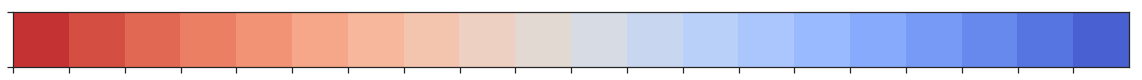

In [118]:
sns.palplot(sns.color_palette("coolwarm", 20)[::-1])

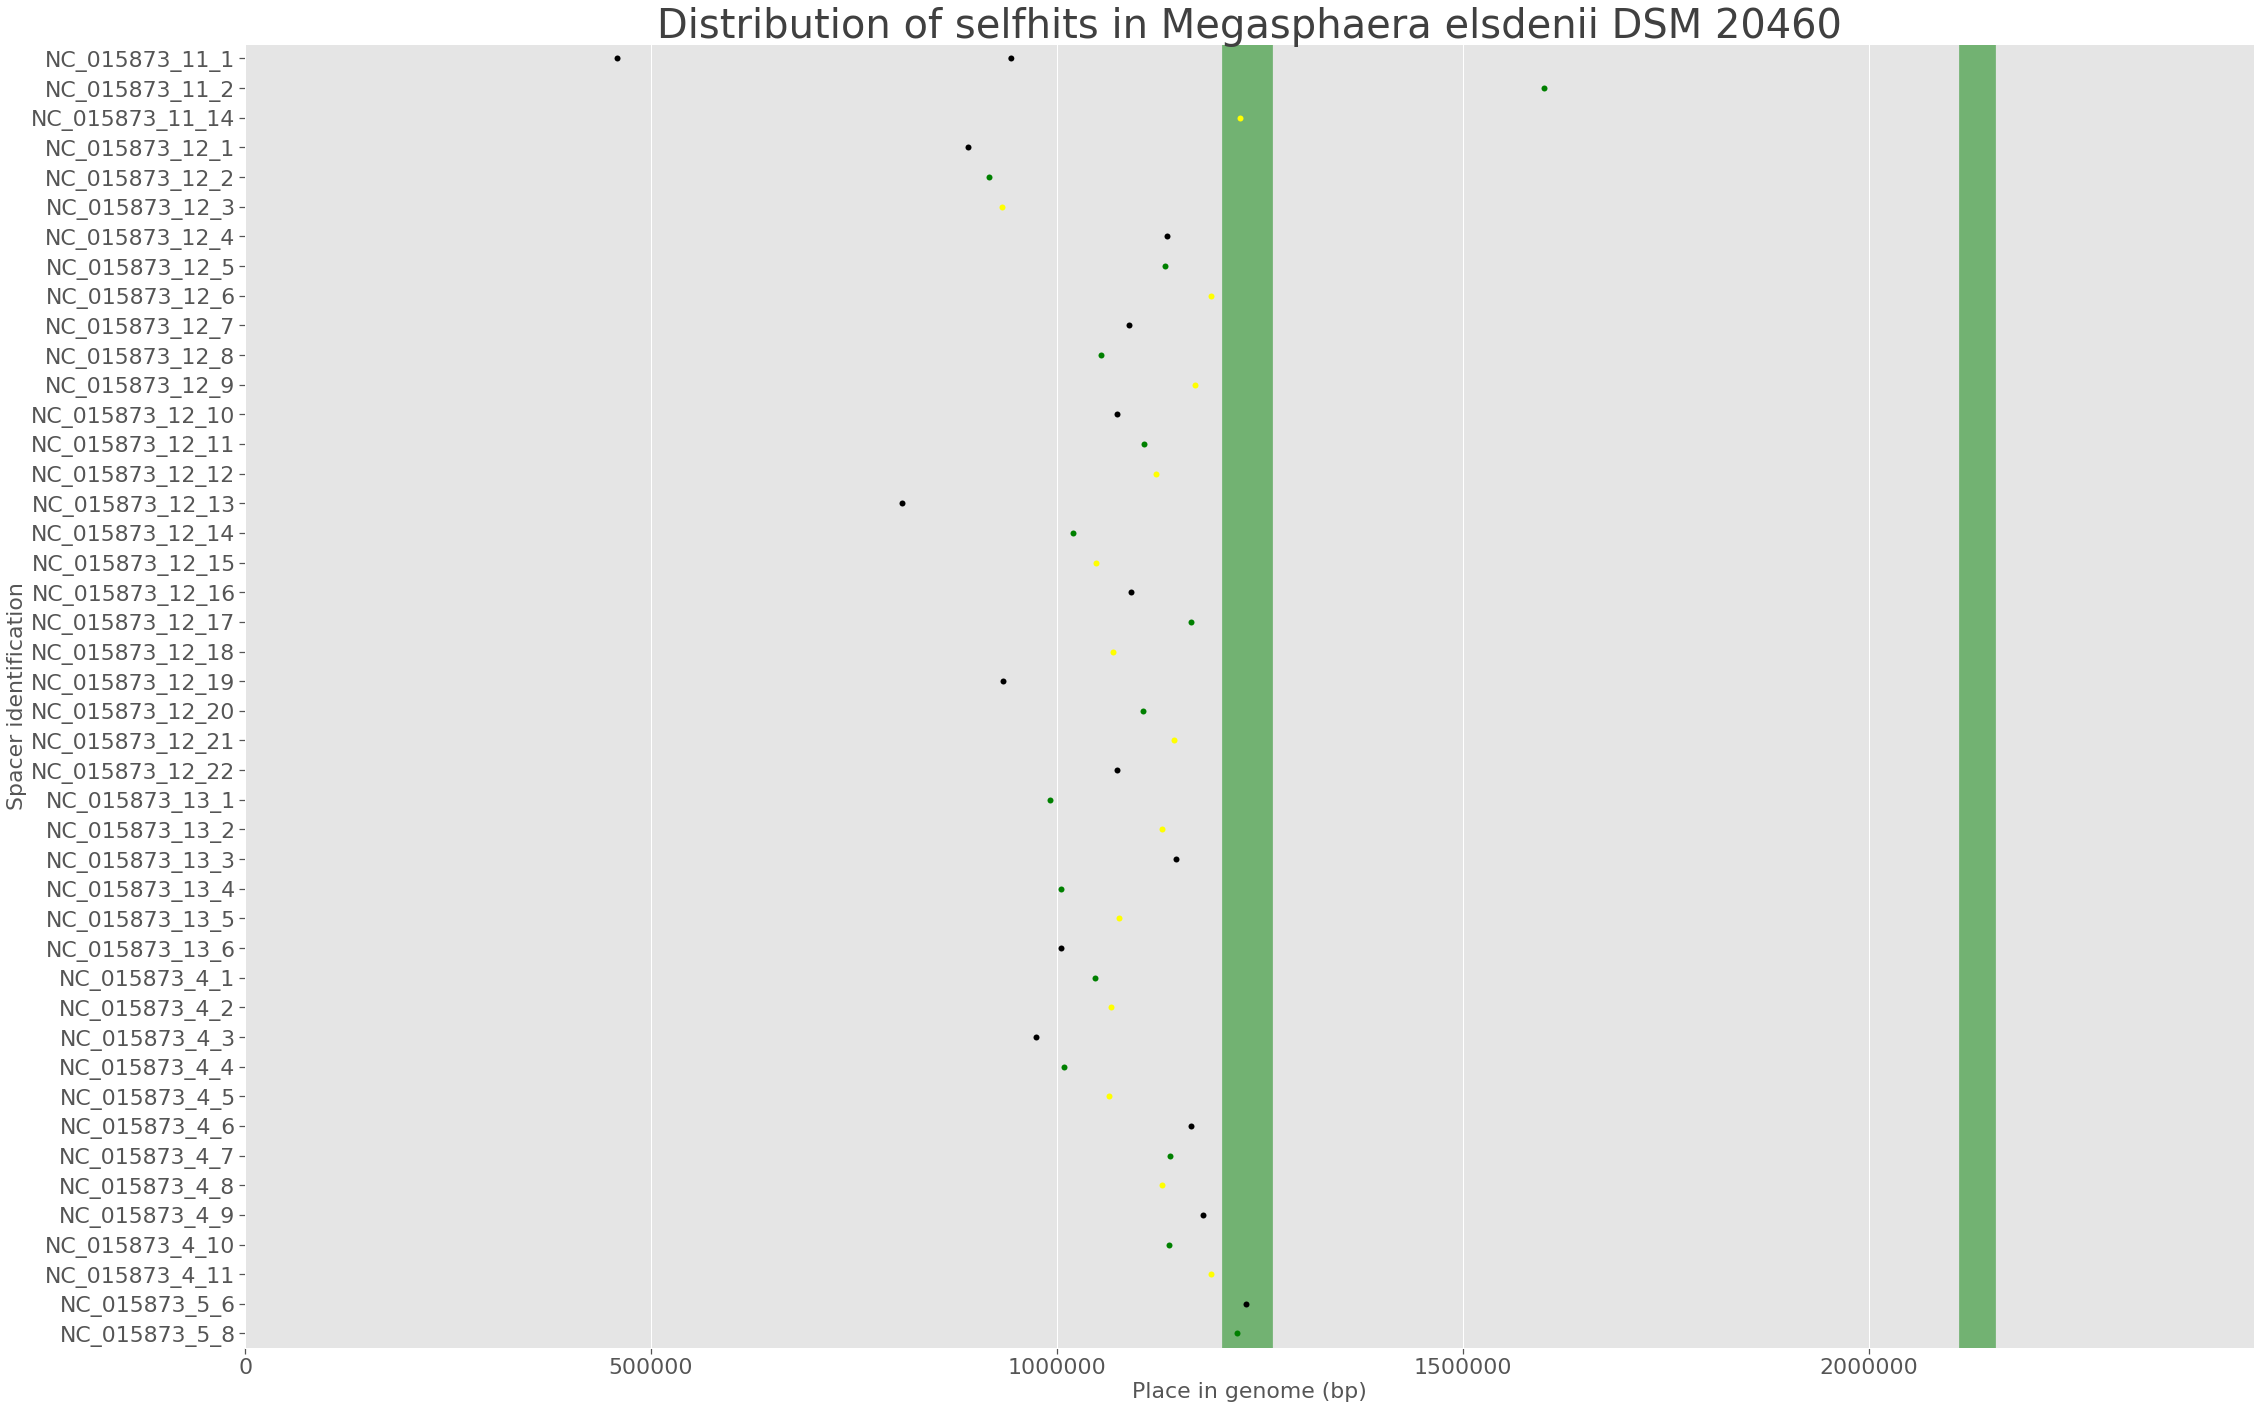

In [154]:
# plt.style.use('ggplot')
if True:
    ax = sns.stripplot(data=dfa.sort_values(by=['array_id', 'spacer_pos']), 
                       x='start_genome', jitter=0, size=6, y='spacer_id', 
                       palette='black')
    increase_size_by(6, 22, plt)
    # import matplotlib.transforms as mtransforms
    # trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    for span in virsorter_coords:
        ax.axvspan(span[0], span[1], alpha=.5, color='green')
    # plt.savefig("place_of_hits_" + genome + ".png", format='png', bbox_inches='tight')
    plt.xlim((1, max_length))
    plt.title("Distribution of selfhits in %s" % df_genome_info.loc[genome]['name'], size=40)
    plt.xlabel("Place in genome (bp)")
    plt.ylabel("Spacer identification")
    # plt.savefig("/home/hielke/bep/jups/bep_figs/%s.png" % genome, format='png', bbox_inches='tight')

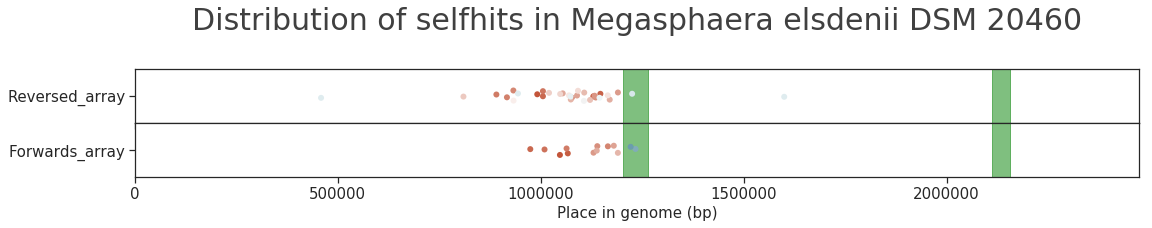

In [237]:
if genome == "907.4":
    # Specific plot for this genome:
    # CRISPR Detect splits the arrays incorrectly: 1-3 (Forward), 4-6 (Forward), 7-9 (Reverse), 10-13 (Reverse) 
    # are single arrays 
    # based on adjacency and equal CRISPR repeat.
    # 
    # There are self-hits in 4-6 (Forward) and 10-13 (Reverse)
    # The size of these are:
    # 4: 22
    # 5: 8
    # 6: 4
    #
    # 10: 2
    # 11: 21
    # 12: 22
    # 13: 6
    #
    # Cumulative (NB 10-13 is Reverse)
    #
    # 4: 0
    # 5: 22
    # 6: 30
    # (size: 34)
    #
    # 10: 49
    # 11: 28
    # 12: 6
    # 13: 0
    # (size: 51)
    actual_spacer_pos_start = {
        4: 0, 
        5: 22, 
        6: 30, 
        10: 49,
        11: 28, 
        12: 6,
        13: 0,
    }
    dfa = dfa.pipe(lambda d:
             d.assign(
             array=np.where(
                 d['array_id'].str.len() == 12, "Reversed_array", "Forwards_array"),
             actual_spacer_pos=
                  d['array_id'].str.split('_').str.get(-1).astype(int).apply(actual_spacer_pos_start.get)
                  + d['spacer_pos'])
    )
    
    # Plotting
    fig_size = (2, 1)
    fig, axes = plt.subplots(*fig_size, sharex=True, )
    palette = lambda array_size: sns.color_palette("coolwarm", array_size)[::-1]
    palette = lambda array_size: sns.diverging_palette(20, 220, n=array_size,)
    plot_names = ["Reversed_array", "Forwards_array"]
    
    def plot_array(array_name, array_size, ax):
        spacer_pos_palette = [0] + palette(array_size)
        this_array = dfa.query('array == @array_name').sort_values(by='actual_spacer_pos')
        spacer_pos_palette_reversed = [spacer_pos_palette[i] for i in this_array['actual_spacer_pos'].values]
        sns.stripplot(data=this_array, ax=ax, 
                       x='start_genome', jitter=True, size=6, 
                      y='array', hue='actual_spacer_pos',
                       palette=spacer_pos_palette_reversed,)
        
    plot_array(plot_names[0], 51, axes[0])
    plot_array(plot_names[1], 34, axes[1])
        
    # add virsorter coords
    for span in virsorter_coords:
        for ax in axes:
            ax.axvspan(span[0], span[1], alpha=.5, color='green')
    # Figure clean-up
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xlim((1, max_length))
    increase_figsize((3, .5))
    for ind, ax in enumerate(axes):
        ax.set_ylabel("")
        ax.get_legend().remove()
    plt.title("Distribution of selfhits in %s" % df_genome_info.loc[genome]['name'], size=30, y=2.6)
    plt.xlabel("Place in genome (bp)")

In [181]:
this_array

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,orientation,start_genome,array,actual_spacer_pos
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
907.4,TAAAGTTGTCTTGATTCTTAGTTTATCATGGATAGG,991552,991587,NC_015873,1,NC_015873_13_1,100.0000,36,2474718,NC_015873_13,6,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAACGACATT,3,5,1,INTERGENIC,NULL,NULL,0.000000,leader,True,991552,Reversed_array,1
907.4,TATACATCAGGAGGCTCTAAATTAAATGAAACGAGC,1129712,1129747,NC_015873,2,NC_015873_13_2,100.0000,36,2474718,NC_015873_13,6,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAATTAGTT,3,5,1,RNA-,NC_015873_974,"Restriction endonuclease, type II, DpmII-like",0.200000,middle,True,1129712,Reversed_array,2
907.4,CTGAATGGGACCTGGAAAAATGCGTCCAGTGTAC,1147100,1147132,NC_015873,3,NC_015873_13_3,97.0588,34,2474718,NC_015873_13,6,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAACGGTCGA,3,5,1,RNA-,NC_015873_985,Transketolase C-terminal/Pyruvate-ferredoxin o...,0.400000,middle,True,1147100,Reversed_array,3
907.4,AATGAAACCGATGAAACGGTCAACAAGAAGACCAA,1005515,1005549,NC_015873,4,NC_015873_13_4,100.0000,35,2474718,NC_015873_13,6,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAATACGTA,3,5,1,RNA-,NC_015873_870,Triosephosphate isomerase,0.600000,middle,True,1005515,Reversed_array,4
907.4,GGCATGGACACGCTGACGGCGGACGGACCGGCCAAGC,1076511,1076546,NC_015873,5,NC_015873_13_5,97.2973,37,2474718,NC_015873_13,6,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAGAGCTTG,3,5,1,RNA-,NC_015873_923,Bacterial lipid A biosynthesis acyltransferase,0.800000,middle,True,1076511,Reversed_array,5
907.4,AATGAAACCGATGAAACGGTCAACAAGAAGACCAA,1005515,1005549,NC_015873,6,NC_015873_13_6,100.0000,35,2474718,NC_015873_13,6,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAATACGTA,3,5,1,RNA-,NC_015873_870,Triosephosphate isomerase,1.000000,tail,True,1005515,Reversed_array,6
907.4,ACCTTCCTCAGCAAGGAAGAAATCGACGCCCTGGC,890851,890885,NC_015873,1,NC_015873_12_1,100.0000,35,2474718,NC_015873_12,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAGTATTTC,3,5,1,RNA-,NC_015873_761,Tyrosine-tRNA ligase,0.000000,leader,True,890851,Reversed_array,7
907.4,ATCGGCTGGATCACGGGCATCGAAGGGGTCTACTTCC,916846,916881,NC_015873,2,NC_015873_12_2,97.2973,37,2474718,NC_015873_12,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAAGTTCGGC,3,5,1,RNA-,NC_015873_792,SecY/SEC61-alpha family,0.047619,middle,True,916846,Reversed_array,8
907.4,TTATAATTACAACGCAGAGGAGTAAGGTGACCAC,932715,932747,NC_015873,3,NC_015873_12_3,97.0588,34,2474718,NC_015873_12,22,9.26,32,CAS-TypeIC,CAS-TypeIC/F,1,GAACTTCATA,3,5,1,RNA-,NC_015873_813,"Glycosyl transferase, family 1",0.095238,middle,True,932715,Reversed_array,9


In [148]:
print(type(spacer_pos_palette))
ding = np.array(spacer_pos_palette)

<class 'list'>


ValueError: setting an array element with a sequence.

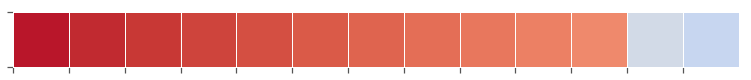

In [163]:
spacer_pos_palette = [
    spacer_pos_palette[i] 
    for i in dfa.query('array == "Reversed_array"')['actual_spacer_pos'].sort_values().values]
sns.palplot(spacer_pos_palette)

In [120]:
[0] + sns.color_palette("coolwarm", 51)

[0,
 (0.24809121780392157, 0.3260130233176471, 0.7776686513529412),
 (0.2711042956470588, 0.3600106619764706, 0.8070951274352941),
 (0.29471843211764703, 0.39354192974117647, 0.8343841671215686),
 (0.31883238319215684, 0.4266050511215686, 0.8598574482039216),
 (0.34327752343529416, 0.45935363472941176, 0.8841219216235294),
 (0.36850661331764706, 0.49114119363137254, 0.9052431282117647),
 (0.3940416781333333, 0.5224134538666667, 0.9249162929333333),
 (0.4199907090352941, 0.5529885453176471, 0.9426303421882353),
 (0.4464306424156863, 0.5823564265411765, 0.9573733054862745),
 (0.4730701729882353, 0.6110774376156862, 0.970633588262745),
 (0.500030564517647, 0.6385084675764706, 0.9810701241058823),
 (0.5271322591215686, 0.664699602117647, 0.9890646466823529),
 (0.5543118699137254, 0.6900970112156862, 0.9955155482352941),
 (0.5760512925333333, 0.7087798786666667, 0.997754592),
 (0.603162067917647, 0.7315274773529412, 0.9995652785372549),
 (0.6300885300352941, 0.7525162397058823, 0.9985080123

In [116]:
dfa['array_id'].str.split('_').str.get(2)

genome_id
907.4     4
907.4     4
907.4     4
907.4    13
907.4    13
907.4    12
907.4     4
907.4    12
907.4    12
907.4    12
907.4    12
907.4    12
907.4    12
907.4    12
907.4     4
907.4    12
907.4     4
907.4    12
907.4    12
907.4     4
907.4     4
907.4     4
907.4    12
907.4    13
907.4     5
907.4    11
907.4    11
907.4     4
907.4    12
907.4     5
907.4    13
907.4    12
907.4    12
907.4    11
907.4    13
907.4    13
907.4    12
907.4    12
907.4    12
907.4     4
907.4    12
907.4    12
907.4    11
907.4    12
907.4    12
Name: array_id, dtype: object

In [109]:
print(A)

None
